In [26]:
# Imports
import numpy as np
import pandas as pd
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline    

#加载原始数据
raw_data_train = pd.read_csv(r"./dataSets/train.csv", encoding='gbk')
raw_data_test = pd.read_csv(r"./dataSets/test.csv", encoding='gbk')

#缺失值处理
train_data = raw_data_train.fillna(0)
train_feature_data = (train_data.drop(['id','label1','label2'],axis=1))
train_target = train_data.label2
X_train = train_feature_data.values.astype(np.float32)

test_data = raw_data_test.fillna(0)
test_feature_data = (test_data.drop(['id','label1','label2'],axis=1))
test_target = test_data.label2
X_test = test_feature_data.values.astype(np.float32)

X_train, _, y_train, _ = train_test_split(X_train, train_target, test_size=0.0, random_state=123)
_, X_test, _, y_test = train_test_split(X_test, test_target, test_size=0.9999, random_state=123)

In [27]:
#加载原始数据
#raw_data = pd.read_csv(r"./creditGrade_train_data.csv", encoding='gbk')
#data = raw_data.fillna(0)
#features_data = (data.drop(['id','label1','label2'],axis=1))
#5-class
#target = data.label2
#X = features_data.values.astype(np.float32) # 转换数据类型
#X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=123) # 参数test_size设置训练集占比

In [28]:
#Normalization
from sklearn import preprocessing
# l2正则化
X_train = preprocessing.normalize(X_train, norm='l2')
X_test = preprocessing.normalize(X_test, norm='l2')
print(X_train)


[[  2.01437473e-01   0.00000000e+00   2.17514172e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.90476266e-02   0.00000000e+00   1.65245622e-01 ...,   7.08895456e-03
    1.36673189e-04   2.60942634e-02]
 [  1.11642247e-03   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  6.29723221e-02   0.00000000e+00   1.66234493e-01 ...,   8.97091231e-05
    0.00000000e+00   1.16708950e-04]
 [  1.07931413e-01   0.00000000e+00   1.36101902e-01 ...,   2.62339599e-03
    3.63099825e-05   2.48723361e-03]
 [  9.69535932e-02   0.00000000e+00   1.26169785e-03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [25]:
#对分类进行one-hot编码
y_tr = one_hot(y_train.astype(np.int64),5)
y_vld = one_hot(y_test.astype(np.int64),5)
print(X_train.shape)
print(X_test.shape)
print("train num:", len(y_tr))
print("val num:", len(y_vld))

(2600, 106)
(100, 106)
train num: 2600
val num: 100


In [43]:
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("tensorflow运行版本：" + tf.__version__)
#设置相关参数
batch_size = 2600  # Batch size
features_num = 106        # Number of steps
learning_rate = 0.00025
epochs = 5000
n_classes = 5
lambda1 = 0.003
log_dir = r'./logs'    # 输出日志保存的路径

graph = tf.Graph()
# Construct placeholders
with graph.as_default():
    in_units = 106
    h1_units = 900
    h2_units = 1024
    #第一层全连接层参数
    W1 = tf.Variable(tf.truncated_normal([in_units, h1_units], stddev=0.1))
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(W1))
    b1 = tf.Variable(tf.zeros([h1_units]))
    
    #第二层卷积层参数
    Wconv1 = tf.Variable(tf.truncated_normal([3, 3, 1, 32], stddev=0.1))
    #tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(Wconv1))
    bconv1 = tf.Variable(tf.constant(0.1, shape=[32]))
    
    #第三层卷积层参数
    Wconv2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1))
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(Wconv2))
    bconv2 = tf.Variable(tf.constant(0.1, shape=[32]))
    
    #第四层全连接层参数
    W2 = tf.Variable(tf.truncated_normal([15*15*32, h2_units], stddev=0.1))
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(W2))
    b2 = tf.Variable(tf.zeros([h2_units]))
    
    #第五层全连接层参数
    W3 = tf.Variable(tf.zeros([h2_units, 5]))
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(W3))
    b3 = tf.Variable(tf.zeros([5]))    
    
    #构造网络
    inputs_ = tf.placeholder(tf.float32, [None, 106], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, 5], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'prob')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    inputs_ = tf.nn.dropout(inputs_, keep_prob_)
    #第一层全连接层，将维度拓展到784
    hidden1 = tf.nn.relu(tf.matmul(inputs_, W1) + b1)
    hidden1_drop = tf.nn.dropout(hidden1, keep_prob_)
    
    #将数据转换为2维，送入第二层卷积层
    hidden1_drop = tf.reshape(hidden1_drop, [-1, 30, 30, 1])
    h_conv1 = tf.nn.relu(tf.nn.conv2d(hidden1_drop, Wconv1, strides=[1, 1, 1, 1], padding='SAME') + bconv1)
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool1 = tf.nn.dropout(h_pool1, keep_prob_)
    
    #第三层卷积层
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, Wconv2, strides=[1, 1, 1, 1], padding='SAME') + bconv2)
    #h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
    #h_pool2 = tf.reshape(h_pool2, [-1, 5*5*64])  #将数据转换为1维
    h_pool2 = tf.nn.dropout(h_conv2, keep_prob_)
    
    h_pool2 = tf.reshape(h_pool2, [-1, 15*15*32])  #将数据转换为1维
    #第四层全连接层，将维度转换为500
    hidden2 = tf.nn.relu(tf.matmul(h_pool2, W2) + b2)
    hidden2_drop = tf.nn.dropout(hidden2, keep_prob_)
    
    #第五层全连接层，维度转换为5，进行5分类
    output_ = tf.matmul(hidden2_drop, W3) + b3
    # Cost function and optimizer
    #二次代价函数，计算预测值与真实值之间的误差代价值-loss，其中第一个参数logits为最后一层输出，第二个为训练目标值即分类值
    #先通过Softmax函数，输出X对应输出每一类的概率大小，其次和真实值进行“交叉熵”，最终，对向量求均值，得到代价loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_, labels=labels_))
    tf.add_to_collection('losses', loss)
    cost = tf.add_n(tf.get_collection('losses'))
    #cost = loss
    
    #梯度下降法，数据量选择AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    #correct_pred 返回一个布尔型数组，通过转化为0-1值后来计算准确率
    correct_pred = tf.equal(tf.argmax(output_, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    #预测值
    pred = tf.argmax(output_, 1, name='cnn')
    print(pred)
    #正确值
    label = tf.argmax(labels_, 1)

tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar('loss_function', cost)

if (os.path.exists(r'./checkpoints') == False):
    !mkdir checkpoints

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    # summaries合并
    merged = tf.summary.merge_all()    
    # 写到指定的磁盘路径中
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_tr, batch_size):
            x = x.reshape((batch_size,features_num))
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y,keep_prob_ : 0.45, learning_rate_ : learning_rate}
             # Loss
            summary_str, loss, _ , acc = sess.run([merged, cost, optimizer, accuracy], feed_dict = feed)
         
            train_acc.append(acc)
            train_loss.append(loss)
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
                train_writer.add_summary(summary_str, e);
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                x_v = X_test.reshape(-1, features_num)
                y_v = y_vld
                feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0} 
                summary, loss_v, acc_v, pred_labels = sess.run([merged, cost, accuracy, pred], feed_dict = feed)                    
                val_acc_.append(acc_v)
                val_loss_.append(loss_v)
                
                #for x_v, y_v in get_batches(X_test, y_vld, batch_size):
                    #x_v = x_v.reshape(batch_size, features_num)
                    # Feed
                    #feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}                      
                    # Loss
                    #summary, loss_v, acc_v, pred_labels = sess.run([merged, cost, accuracy, pred], feed_dict = feed)                    
                    #val_acc_.append(acc_v)
                    #val_loss_.append(loss_v)
                    
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                test_writer.add_summary(summary, e);
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            # Iterate 
            iteration += 1    
            
        
#     # 保存二进制模型
#     output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['labels'])
#     with tf.gfile.FastGFile(r'D:\py_projects\ML\ML_Demo\financial\creditGrade.pb', mode='wb') as f:
#         f.write(output_graph_def.SerializeToString())

    saver.save(sess,"checkpoints-cnn/creditGrade.ckpt")

    # 保存二进制模型
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['cnn'])
    with tf.gfile.FastGFile(r'cnn.pb', mode='wb') as f:
        f.write(output_graph_def.SerializeToString())

tensorflow运行版本：1.3.0
Tensor("cnn:0", shape=(?,), dtype=int64)
Epoch: 4/5000 Iteration: 5 Train loss: 86.496323 Train acc: 0.471154
Epoch: 9/5000 Iteration: 10 Train loss: 84.506325 Train acc: 0.471154
Epoch: 9/5000 Iteration: 10 Validation loss: 84.227013 Validation acc: 0.440000
Epoch: 14/5000 Iteration: 15 Train loss: 82.540886 Train acc: 0.471154
Epoch: 19/5000 Iteration: 20 Train loss: 80.650345 Train acc: 0.471154
Epoch: 19/5000 Iteration: 20 Validation loss: 80.375511 Validation acc: 0.440000
Epoch: 24/5000 Iteration: 25 Train loss: 78.787941 Train acc: 0.471154
Epoch: 29/5000 Iteration: 30 Train loss: 76.974236 Train acc: 0.471154
Epoch: 29/5000 Iteration: 30 Validation loss: 76.715675 Validation acc: 0.440000
Epoch: 34/5000 Iteration: 35 Train loss: 75.199036 Train acc: 0.471154
Epoch: 39/5000 Iteration: 40 Train loss: 73.471191 Train acc: 0.471154
Epoch: 39/5000 Iteration: 40 Validation loss: 73.230507 Validation acc: 0.440000
Epoch: 44/5000 Iteration: 45 Train loss: 71.784805

Epoch: 364/5000 Iteration: 365 Train loss: 16.264938 Train acc: 0.556538
Epoch: 369/5000 Iteration: 370 Train loss: 15.887785 Train acc: 0.565385
Epoch: 369/5000 Iteration: 370 Validation loss: 15.834915 Validation acc: 0.540000
Epoch: 374/5000 Iteration: 375 Train loss: 15.511174 Train acc: 0.564615
Epoch: 379/5000 Iteration: 380 Train loss: 15.152331 Train acc: 0.561154
Epoch: 379/5000 Iteration: 380 Validation loss: 15.111995 Validation acc: 0.550000
Epoch: 384/5000 Iteration: 385 Train loss: 14.791865 Train acc: 0.586154
Epoch: 389/5000 Iteration: 390 Train loss: 14.461596 Train acc: 0.567692
Epoch: 389/5000 Iteration: 390 Validation loss: 14.416246 Validation acc: 0.530000
Epoch: 394/5000 Iteration: 395 Train loss: 14.116766 Train acc: 0.579231
Epoch: 399/5000 Iteration: 400 Train loss: 13.784970 Train acc: 0.573077
Epoch: 399/5000 Iteration: 400 Validation loss: 13.754872 Validation acc: 0.530000
Epoch: 404/5000 Iteration: 405 Train loss: 13.460133 Train acc: 0.583077
Epoch: 409/

Epoch: 729/5000 Iteration: 730 Train loss: 2.655426 Train acc: 0.903846
Epoch: 729/5000 Iteration: 730 Validation loss: 2.861913 Validation acc: 0.810000
Epoch: 734/5000 Iteration: 735 Train loss: 2.579524 Train acc: 0.917692
Epoch: 739/5000 Iteration: 740 Train loss: 2.526285 Train acc: 0.908846
Epoch: 739/5000 Iteration: 740 Validation loss: 2.756802 Validation acc: 0.780000
Epoch: 744/5000 Iteration: 745 Train loss: 2.457534 Train acc: 0.916538
Epoch: 749/5000 Iteration: 750 Train loss: 2.397440 Train acc: 0.919615
Epoch: 749/5000 Iteration: 750 Validation loss: 2.622327 Validation acc: 0.810000
Epoch: 754/5000 Iteration: 755 Train loss: 2.326274 Train acc: 0.923461
Epoch: 759/5000 Iteration: 760 Train loss: 2.278409 Train acc: 0.919231
Epoch: 759/5000 Iteration: 760 Validation loss: 2.509172 Validation acc: 0.790000
Epoch: 764/5000 Iteration: 765 Train loss: 2.215590 Train acc: 0.925385
Epoch: 769/5000 Iteration: 770 Train loss: 2.162705 Train acc: 0.927308
Epoch: 769/5000 Iteratio

Epoch: 1094/5000 Iteration: 1095 Train loss: 0.494061 Train acc: 0.969615
Epoch: 1099/5000 Iteration: 1100 Train loss: 0.480158 Train acc: 0.972308
Epoch: 1099/5000 Iteration: 1100 Validation loss: 0.799798 Validation acc: 0.810000
Epoch: 1104/5000 Iteration: 1105 Train loss: 0.477723 Train acc: 0.969615
Epoch: 1109/5000 Iteration: 1110 Train loss: 0.470764 Train acc: 0.971154
Epoch: 1109/5000 Iteration: 1110 Validation loss: 0.772740 Validation acc: 0.830000
Epoch: 1114/5000 Iteration: 1115 Train loss: 0.450417 Train acc: 0.973077
Epoch: 1119/5000 Iteration: 1120 Train loss: 0.446624 Train acc: 0.973461
Epoch: 1119/5000 Iteration: 1120 Validation loss: 0.769125 Validation acc: 0.800000
Epoch: 1124/5000 Iteration: 1125 Train loss: 0.440188 Train acc: 0.976538
Epoch: 1129/5000 Iteration: 1130 Train loss: 0.435944 Train acc: 0.973846
Epoch: 1129/5000 Iteration: 1130 Validation loss: 0.742900 Validation acc: 0.840000
Epoch: 1134/5000 Iteration: 1135 Train loss: 0.425213 Train acc: 0.97500

Epoch: 1449/5000 Iteration: 1450 Train loss: 0.214928 Train acc: 0.985769
Epoch: 1449/5000 Iteration: 1450 Validation loss: 0.579913 Validation acc: 0.820000
Epoch: 1454/5000 Iteration: 1455 Train loss: 0.221292 Train acc: 0.981923
Epoch: 1459/5000 Iteration: 1460 Train loss: 0.219915 Train acc: 0.982692
Epoch: 1459/5000 Iteration: 1460 Validation loss: 0.560472 Validation acc: 0.820000
Epoch: 1464/5000 Iteration: 1465 Train loss: 0.224965 Train acc: 0.977692
Epoch: 1469/5000 Iteration: 1470 Train loss: 0.215497 Train acc: 0.982308
Epoch: 1469/5000 Iteration: 1470 Validation loss: 0.573641 Validation acc: 0.810000
Epoch: 1474/5000 Iteration: 1475 Train loss: 0.215477 Train acc: 0.984231
Epoch: 1479/5000 Iteration: 1480 Train loss: 0.215637 Train acc: 0.982308
Epoch: 1479/5000 Iteration: 1480 Validation loss: 0.559154 Validation acc: 0.840000
Epoch: 1484/5000 Iteration: 1485 Train loss: 0.216012 Train acc: 0.978846
Epoch: 1489/5000 Iteration: 1490 Train loss: 0.213863 Train acc: 0.98038

Epoch: 1804/5000 Iteration: 1805 Train loss: 0.178384 Train acc: 0.985384
Epoch: 1809/5000 Iteration: 1810 Train loss: 0.175600 Train acc: 0.985385
Epoch: 1809/5000 Iteration: 1810 Validation loss: 0.564969 Validation acc: 0.800000
Epoch: 1814/5000 Iteration: 1815 Train loss: 0.177346 Train acc: 0.984231
Epoch: 1819/5000 Iteration: 1820 Train loss: 0.177068 Train acc: 0.986538
Epoch: 1819/5000 Iteration: 1820 Validation loss: 0.561570 Validation acc: 0.840000
Epoch: 1824/5000 Iteration: 1825 Train loss: 0.178048 Train acc: 0.985769
Epoch: 1829/5000 Iteration: 1830 Train loss: 0.176989 Train acc: 0.983077
Epoch: 1829/5000 Iteration: 1830 Validation loss: 0.548380 Validation acc: 0.840000
Epoch: 1834/5000 Iteration: 1835 Train loss: 0.176202 Train acc: 0.985385
Epoch: 1839/5000 Iteration: 1840 Train loss: 0.173331 Train acc: 0.987692
Epoch: 1839/5000 Iteration: 1840 Validation loss: 0.554946 Validation acc: 0.800000
Epoch: 1844/5000 Iteration: 1845 Train loss: 0.180735 Train acc: 0.98384

Epoch: 2159/5000 Iteration: 2160 Train loss: 0.162178 Train acc: 0.987308
Epoch: 2159/5000 Iteration: 2160 Validation loss: 0.577137 Validation acc: 0.810000
Epoch: 2164/5000 Iteration: 2165 Train loss: 0.165227 Train acc: 0.985000
Epoch: 2169/5000 Iteration: 2170 Train loss: 0.161793 Train acc: 0.986923
Epoch: 2169/5000 Iteration: 2170 Validation loss: 0.566188 Validation acc: 0.810000
Epoch: 2174/5000 Iteration: 2175 Train loss: 0.159219 Train acc: 0.988846
Epoch: 2179/5000 Iteration: 2180 Train loss: 0.161890 Train acc: 0.985769
Epoch: 2179/5000 Iteration: 2180 Validation loss: 0.559429 Validation acc: 0.790000
Epoch: 2184/5000 Iteration: 2185 Train loss: 0.161865 Train acc: 0.986538
Epoch: 2189/5000 Iteration: 2190 Train loss: 0.156812 Train acc: 0.990385
Epoch: 2189/5000 Iteration: 2190 Validation loss: 0.553594 Validation acc: 0.810000
Epoch: 2194/5000 Iteration: 2195 Train loss: 0.160866 Train acc: 0.990000
Epoch: 2199/5000 Iteration: 2200 Train loss: 0.158845 Train acc: 0.98846

Epoch: 2514/5000 Iteration: 2515 Train loss: 0.153623 Train acc: 0.985000
Epoch: 2519/5000 Iteration: 2520 Train loss: 0.152876 Train acc: 0.985385
Epoch: 2519/5000 Iteration: 2520 Validation loss: 0.541526 Validation acc: 0.840000
Epoch: 2524/5000 Iteration: 2525 Train loss: 0.148970 Train acc: 0.989231
Epoch: 2529/5000 Iteration: 2530 Train loss: 0.151944 Train acc: 0.988846
Epoch: 2529/5000 Iteration: 2530 Validation loss: 0.547968 Validation acc: 0.800000
Epoch: 2534/5000 Iteration: 2535 Train loss: 0.150801 Train acc: 0.990000
Epoch: 2539/5000 Iteration: 2540 Train loss: 0.149009 Train acc: 0.990000
Epoch: 2539/5000 Iteration: 2540 Validation loss: 0.544811 Validation acc: 0.830000
Epoch: 2544/5000 Iteration: 2545 Train loss: 0.155183 Train acc: 0.987308
Epoch: 2549/5000 Iteration: 2550 Train loss: 0.147788 Train acc: 0.989231
Epoch: 2549/5000 Iteration: 2550 Validation loss: 0.565194 Validation acc: 0.810000
Epoch: 2554/5000 Iteration: 2555 Train loss: 0.150660 Train acc: 0.98884

Epoch: 2869/5000 Iteration: 2870 Train loss: 0.144317 Train acc: 0.988077
Epoch: 2869/5000 Iteration: 2870 Validation loss: 0.561146 Validation acc: 0.810000
Epoch: 2874/5000 Iteration: 2875 Train loss: 0.143464 Train acc: 0.988461
Epoch: 2879/5000 Iteration: 2880 Train loss: 0.143508 Train acc: 0.988846
Epoch: 2879/5000 Iteration: 2880 Validation loss: 0.549211 Validation acc: 0.820000
Epoch: 2884/5000 Iteration: 2885 Train loss: 0.146189 Train acc: 0.987692
Epoch: 2889/5000 Iteration: 2890 Train loss: 0.142012 Train acc: 0.989231
Epoch: 2889/5000 Iteration: 2890 Validation loss: 0.541092 Validation acc: 0.830000
Epoch: 2894/5000 Iteration: 2895 Train loss: 0.144672 Train acc: 0.988077
Epoch: 2899/5000 Iteration: 2900 Train loss: 0.147328 Train acc: 0.986538
Epoch: 2899/5000 Iteration: 2900 Validation loss: 0.559135 Validation acc: 0.810000
Epoch: 2904/5000 Iteration: 2905 Train loss: 0.145805 Train acc: 0.987692
Epoch: 2909/5000 Iteration: 2910 Train loss: 0.140380 Train acc: 0.99115

Epoch: 3224/5000 Iteration: 3225 Train loss: 0.132635 Train acc: 0.990385
Epoch: 3229/5000 Iteration: 3230 Train loss: 0.138342 Train acc: 0.986538
Epoch: 3229/5000 Iteration: 3230 Validation loss: 0.552060 Validation acc: 0.800000
Epoch: 3234/5000 Iteration: 3235 Train loss: 0.135362 Train acc: 0.990000
Epoch: 3239/5000 Iteration: 3240 Train loss: 0.135875 Train acc: 0.987692
Epoch: 3239/5000 Iteration: 3240 Validation loss: 0.562950 Validation acc: 0.810000
Epoch: 3244/5000 Iteration: 3245 Train loss: 0.136531 Train acc: 0.988846
Epoch: 3249/5000 Iteration: 3250 Train loss: 0.134972 Train acc: 0.990769
Epoch: 3249/5000 Iteration: 3250 Validation loss: 0.558289 Validation acc: 0.800000
Epoch: 3254/5000 Iteration: 3255 Train loss: 0.134792 Train acc: 0.990769
Epoch: 3259/5000 Iteration: 3260 Train loss: 0.137604 Train acc: 0.989231
Epoch: 3259/5000 Iteration: 3260 Validation loss: 0.533303 Validation acc: 0.820000
Epoch: 3264/5000 Iteration: 3265 Train loss: 0.135881 Train acc: 0.99000

Epoch: 3579/5000 Iteration: 3580 Train loss: 0.130580 Train acc: 0.989231
Epoch: 3579/5000 Iteration: 3580 Validation loss: 0.554944 Validation acc: 0.810000
Epoch: 3584/5000 Iteration: 3585 Train loss: 0.130305 Train acc: 0.988846
Epoch: 3589/5000 Iteration: 3590 Train loss: 0.133120 Train acc: 0.990000
Epoch: 3589/5000 Iteration: 3590 Validation loss: 0.570811 Validation acc: 0.810000
Epoch: 3594/5000 Iteration: 3595 Train loss: 0.129450 Train acc: 0.990769
Epoch: 3599/5000 Iteration: 3600 Train loss: 0.131329 Train acc: 0.990769
Epoch: 3599/5000 Iteration: 3600 Validation loss: 0.557756 Validation acc: 0.810000
Epoch: 3604/5000 Iteration: 3605 Train loss: 0.129622 Train acc: 0.990385
Epoch: 3609/5000 Iteration: 3610 Train loss: 0.131933 Train acc: 0.988461
Epoch: 3609/5000 Iteration: 3610 Validation loss: 0.541333 Validation acc: 0.810000
Epoch: 3614/5000 Iteration: 3615 Train loss: 0.133133 Train acc: 0.988462
Epoch: 3619/5000 Iteration: 3620 Train loss: 0.134336 Train acc: 0.98846

Epoch: 3934/5000 Iteration: 3935 Train loss: 0.128653 Train acc: 0.987308
Epoch: 3939/5000 Iteration: 3940 Train loss: 0.124965 Train acc: 0.991923
Epoch: 3939/5000 Iteration: 3940 Validation loss: 0.550319 Validation acc: 0.870000
Epoch: 3944/5000 Iteration: 3945 Train loss: 0.126735 Train acc: 0.990384
Epoch: 3949/5000 Iteration: 3950 Train loss: 0.129538 Train acc: 0.987308
Epoch: 3949/5000 Iteration: 3950 Validation loss: 0.547785 Validation acc: 0.820000
Epoch: 3954/5000 Iteration: 3955 Train loss: 0.127727 Train acc: 0.990000
Epoch: 3959/5000 Iteration: 3960 Train loss: 0.126711 Train acc: 0.991538
Epoch: 3959/5000 Iteration: 3960 Validation loss: 0.569477 Validation acc: 0.880000
Epoch: 3964/5000 Iteration: 3965 Train loss: 0.127029 Train acc: 0.990385
Epoch: 3969/5000 Iteration: 3970 Train loss: 0.131509 Train acc: 0.987308
Epoch: 3969/5000 Iteration: 3970 Validation loss: 0.584149 Validation acc: 0.820000
Epoch: 3974/5000 Iteration: 3975 Train loss: 0.129196 Train acc: 0.98923

Epoch: 4289/5000 Iteration: 4290 Train loss: 0.120779 Train acc: 0.991923
Epoch: 4289/5000 Iteration: 4290 Validation loss: 0.586816 Validation acc: 0.790000
Epoch: 4294/5000 Iteration: 4295 Train loss: 0.125183 Train acc: 0.988461
Epoch: 4299/5000 Iteration: 4300 Train loss: 0.126314 Train acc: 0.988461
Epoch: 4299/5000 Iteration: 4300 Validation loss: 0.540605 Validation acc: 0.800000
Epoch: 4304/5000 Iteration: 4305 Train loss: 0.119937 Train acc: 0.991923
Epoch: 4309/5000 Iteration: 4310 Train loss: 0.130289 Train acc: 0.987692
Epoch: 4309/5000 Iteration: 4310 Validation loss: 0.588918 Validation acc: 0.800000
Epoch: 4314/5000 Iteration: 4315 Train loss: 0.123591 Train acc: 0.989231
Epoch: 4319/5000 Iteration: 4320 Train loss: 0.121671 Train acc: 0.991154
Epoch: 4319/5000 Iteration: 4320 Validation loss: 0.555749 Validation acc: 0.810000
Epoch: 4324/5000 Iteration: 4325 Train loss: 0.123279 Train acc: 0.991154
Epoch: 4329/5000 Iteration: 4330 Train loss: 0.123077 Train acc: 0.99038

Epoch: 4644/5000 Iteration: 4645 Train loss: 0.119535 Train acc: 0.989615
Epoch: 4649/5000 Iteration: 4650 Train loss: 0.117187 Train acc: 0.990000
Epoch: 4649/5000 Iteration: 4650 Validation loss: 0.568688 Validation acc: 0.810000
Epoch: 4654/5000 Iteration: 4655 Train loss: 0.116432 Train acc: 0.991538
Epoch: 4659/5000 Iteration: 4660 Train loss: 0.118162 Train acc: 0.990769
Epoch: 4659/5000 Iteration: 4660 Validation loss: 0.569758 Validation acc: 0.810000
Epoch: 4664/5000 Iteration: 4665 Train loss: 0.116997 Train acc: 0.990769
Epoch: 4669/5000 Iteration: 4670 Train loss: 0.120457 Train acc: 0.988461
Epoch: 4669/5000 Iteration: 4670 Validation loss: 0.570874 Validation acc: 0.800000
Epoch: 4674/5000 Iteration: 4675 Train loss: 0.120009 Train acc: 0.989615
Epoch: 4679/5000 Iteration: 4680 Train loss: 0.120520 Train acc: 0.989615
Epoch: 4679/5000 Iteration: 4680 Validation loss: 0.567368 Validation acc: 0.800000
Epoch: 4684/5000 Iteration: 4685 Train loss: 0.123574 Train acc: 0.98769

Epoch: 4999/5000 Iteration: 5000 Train loss: 0.119412 Train acc: 0.990769
Epoch: 4999/5000 Iteration: 5000 Validation loss: 0.593975 Validation acc: 0.810000
INFO:tensorflow:Froze 10 variables.
Converted 10 variables to const ops.


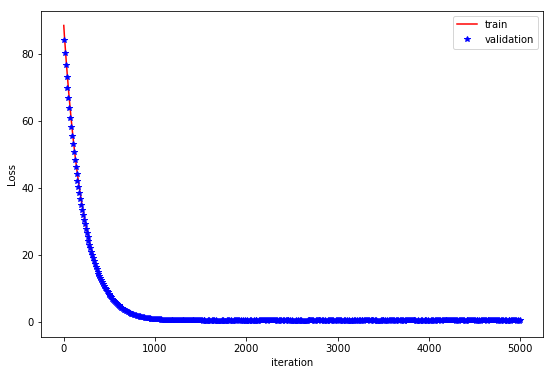

In [45]:
t = np.arange(iteration-1)
#print(np.array(train_loss))
plt.figure(figsize = (9,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

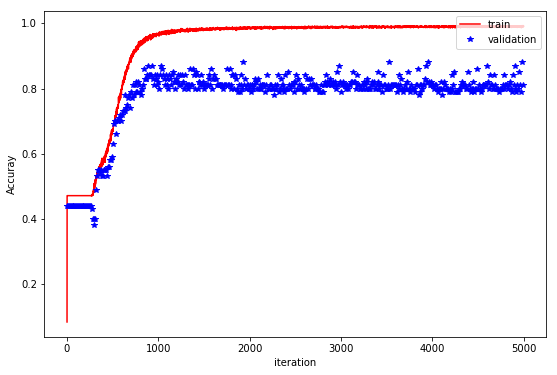

In [46]:
# Plot Accuracies
plt.figure(figsize = (9,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
test_acc = []
pred_labels = []
label = []
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    x_v = X_test.reshape(-1, features_num)
    y_v = y_vld
    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0} 
    batch_acc = sess.run(accuracy, feed_dict=feed)
    preds = sess.run(pred, feed_dict=feed)
    labels = sess.run(label, feed_dict=feed)
    #max_index = np.argmax(prediction)
    #print(max_index)
    test_acc.append(batch_acc)
    pred_labels.append(preds)
    label.append(labels)
    
    #for x_t, y_t in get_batches(X_test, y_vld, batch_size):
        #x_t = x_t.reshape((batch_size, features_num))
        #feed = {inputs_: x_t,
        #        labels_: y_t,
        #        keep_prob_: 1}
       
        #batch_acc = sess.run(accuracy, feed_dict=feed)
        #preds = sess.run(pred, feed_dict=feed)
        #labels = sess.run(label, feed_dict=feed)
        #test_acc.append(batch_acc)
        #pred_labels.append(preds)
        #label.append(labels)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    print("pred value", pred_labels)

INFO:tensorflow:Restoring parameters from checkpoints-cnn/creditGrade.ckpt
Test accuracy: 0.810000
pred value [array([1, 2, 2, 2, 1, 0, 2, 0, 1, 1, 2, 1, 1, 3, 3, 2, 1, 2, 3, 0, 1, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2, 1, 3, 2, 0, 2, 2, 2, 3, 1, 2, 2, 2,
       0, 1, 3, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 0, 1, 2, 2,
       2, 0, 1, 3, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 2, 2, 2, 0, 2, 1,
       2, 2, 2, 0, 1, 2, 3, 1])]
